# Aumento de datos

No siempre se tienen muchos ejemplos y datos para trabajar con los modelos propuestos. Esta es una de las principales desventajas de utilizar modelos con demasiados parámetros por aprender, como es el caso de las redes neuronales y en especial las convolucionales (CNN).

Sin embargo, una metodología que ha ganado muchos seguidores es el _aumento de datos._ En particular, esta técnica fue creada para imágenes pero posteriormente adaptada para otro tipo de datos, como secuencias y vocabularios. La idea es simple: modificar de alguna forma los ejemplos que se tienen para _hacer creer_ al modelo que son ejemplos _nuevos._

Un caso de esto es agregar **ruido blanco** o gaussiano a las imágenes. Esto se ve como estática en las imágenes, lo que causa que el modelo piense que son imágenes diferentes, imágenes con ruido. Esto crea un efecto de tener más datos de los que en realidad se tienen.

Esta no es la única técnica, también existe la **rotación,** **traslación,** **reflexión sobre un eje,** entre muchas otras. En este documento se van a presentar algunas de las más utilizadas y su efecto en la clasificación de un conjunto de datos.

In [74]:
from keras.datasets import fashion_mnist
from keras.layers import Dense, BatchNormalization, Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten, GaussianNoise
from keras.utils import to_categorical
from keras.models import Sequential
from keras import regularizers
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

## Fashion-MNIST

El conjunto de datos empleado es el [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) que tiene 10 clases, cada una pertenece a un tipo de prenda o de calzado. La idea de este conjunto de datos (en realidad son imágenes) es que sirva como un reemplazo para el famoso conjunto de datos de dígitos escritos a mano del MNIST.

Las imágenes tienen un tamaño de $28 \times 28$ y están en tono de grises.

In [75]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [76]:
# Tamaño de lote para el optimizador
batch_size = 128
# Número de clases, ya se sabe por que se conoce el conjunto de datos
# pero si no, se puede hacer de forma programática
num_classes = 10
# Número de épocas, dejar como está porque es suficiente
epocas = 100
# Parámetro de regularización L2 (Ridge)
regular_param_l2 = 1e-4
# Parámetro de regularización L1 (Lasso)
regular_param_l1 = 5e-5

# Tamaño de las imágenes, ancho y alto
img_rows, img_cols = 28, 28

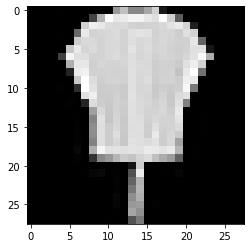

In [77]:
# Se puede visualizar una de estas imágenes para conocer el conjunto de datos
plt.imshow(x_train[56, :, :], cmap="gray")

In [78]:
# Reajustar las imágenes para asegurar que solamente es un canal de color
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
# Tamaño de la entrada, en forma de tupla siempre
input_shape = (img_rows, img_cols, 1)

In [79]:
# Convertir a float32 para mejor manejo
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
# Normalizar los valores de las imágenes
x_train /= 255
x_test /= 255

In [80]:
print("Tamaño del conjunto de entrenamiento:", x_train.shape)
print(x_train.shape[0], "Muestras de entrenamiento")
print(x_test.shape[0], "Muestras de prueba")

Tamaño del conjunto de entrenamiento: (60000, 28, 28, 1)
60000 Muestras de entrenamiento
10000 Muestras de prueba


In [81]:
# Codificación One Hot para las etiquetas
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## Arquitecturas de las CNN

Todas las arquitecturas tienen la misma forma en común, que proviene del [ejemplo de `keras`](https://keras.io/examples/cifar10_cnn/) para la clasificación del conjunto de datos CIFAR-10, solamente que en este caso se emplea otro conjunto de datos como ya se ha explicado anteriormente.

En esta arquitectura se empleará la regularización _ElasticNet_ para los pesos dentro de la CNN. También se va a emplear la regularización _dropout_ con el 25% de unidades de características y un 50% de unidades en la capa totalmente conectada.

In [82]:
# Con regularizador L1 y L2
arquitectura_l1_l2 = [
    # Capa de entrada, primera capa de características
    Conv2D(32, kernel_size=(3, 3),
           padding="same",
           input_shape=x_train.shape[1:],
          kernel_regularizer=regularizers.l1_l2(l1=regular_param_l1, l2=regular_param_l2)),
    Activation("relu"),
    Conv2D(32, (3, 3), kernel_regularizer=regularizers.l1_l2(l1=regular_param_l1, l2=regular_param_l2)),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    # Segunda capa de características
    Conv2D(64, kernel_size=(3, 3), padding="same",
          kernel_regularizer=regularizers.l1_l2(l1=regular_param_l1, l2=regular_param_l2)),
    Activation("relu"),
    Conv2D(64, (3, 3), kernel_regularizer=regularizers.l1_l2(l1=regular_param_l1, l2=regular_param_l2)),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    # Capa totalmente conectada
    Flatten(),
    Dense(512, kernel_regularizer=regularizers.l1_l2(l1=regular_param_l1, l2=regular_param_l2)),
    Dropout(0.5),
    Activation("relu"),
    # Capa de salida
    Dense(num_classes, activation="softmax")
]

In [83]:
modelo_l1_l2 = Sequential(arquitectura_l1_l2)

## Optimización y entrenamiento

Este modelo será entrenado con descenso de gradiente estocástico con ratio de aprendizaje 0.001 y momento clásico de 0.9.

El entrenamiento será validado con el 20% de ejemplos del conjunto de entrenamiento, y después será evaluado con el conjunto de prueba que se separó al principio, en el preprocesamiento de datos.

In [84]:
modelo_l1_l2.compile(loss="categorical_crossentropy",
                 optimizer=SGD(lr=0.001, momentum=0.9),
                 metrics=["accuracy"])

## Preprocesamiento de datos junto con aumento

En esta parte se implementa la utilidad de `keras` que se llama `ImageDataGenerator`. Esta utilidad toma un conjunto de datos y los procesa, luego va generando de forma _retardada_ los conjuntos de datos según el modelo los va solicitando.

En este caso se van a utilizar las siguientes transformaciones:

- La **traslación** con un valor de 0.1 hacia _verticalmente_ y _horizontalmente._

- Se va a utilizar el **acercamiento**, con un valor de aumento de 20%.

- **Relleno** en las orillas de la imagen empleando el método de _vecinos más cercanos._

- **Reflexión** sobre los ejes vertical y horizontales.

In [85]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # si es positivo, la media del conjunto de datos es 0
        samplewise_center=False,  # si es positivo, la medida de cada ejemplo es 0
        featurewise_std_normalization=False,  # divide el conjunto de datos por la desviación estándar
        samplewise_std_normalization=False,  # divide cada ejemplo por su propia desviación estándar
        zca_whitening=False,  # aplicar ruido tipo Zero-phase Component Analysis
        zca_epsilon=1e-06,  # valor del ruido tipo ZCA
        rotation_range=0,  # se rota aleatoriamente la imagen, el valor es entero de 0 a 180
        # traslación horizontal aleatoria, la fracción representa cuánto
        width_shift_range=0.1,
        # traslación vertical aleatoria, la fracción representa cuánto
        height_shift_range=0.1,
        shear_range=0.0,  # valor para distorsión
        zoom_range=0.2,  # valor para acercamiento
        channel_shift_range=0.,  # cambio de canales, de forma aleatoria
        # modo para rellenado de pixeles fuera de la imagen
        fill_mode="nearest",
        cval=0.,  # en caso de que el rellenado sea "constant"
        horizontal_flip=True,  # reflexión horizontal aleatoria de las imágenes
        vertical_flip=True,  # reflexión vertical aleatoria de las imágenes
        # factor de reescalamiento (se aplica primero antes que cualquier transformación)
        rescale=None,
        # algún tipo de función definida por el usuario que haga transformaciones
        # i.e. filtro de Borel, transformada de Fourier, ruido rosa, etc.
        preprocessing_function=None,
        # especificar el tipo de datos que se están ingresando
        data_format=None,
        # fracción de imágenes para separar en entrenamieto y validación
        validation_split=0.2)

Con esto se lleva a cabo el entrenamiento, sin embargo se debe hacer de forma diferente. La cuestión es que `keras` crea las imágenes _en el momento_ por lo que el entrenamiento también debe ser de esta forma. Para este tipo de procesamiento se debe de llamar las funciones de entrenamiento de otra forma, como se verá a continuación.

También es importante notar que como son _flujos de datos,_ el modelo no conoce el tamaño del flujo antes de procesarlo, por lo que hay que definirlo mediante las opciones `steps_per_epoch` y `validation_steps`, como se muestra a continuación.

In [86]:
datagen.fit(x_train)
modelo_l1_l2.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size,
                                       subset="training"),
                        epochs=epocas,
                        validation_data=datagen.flow(x_train, y_train,
                                     batch_size=batch_size,
                                       subset="validation"),
                        steps_per_epoch=np.ceil(len(x_train) // batch_size),
                        validation_steps=np.ceil(len(x_train) // batch_size),
                        workers=4)

Epoch 1/100
468/468 [==============================] - 111s 237ms/step - loss: 3.4181 - acc: 0.2074 - val_loss: 2.8694 - val_acc: 0.4313
Epoch 2/100
468/468 [==============================] - 128s 273ms/step - loss: 2.7973 - acc: 0.4226 - val_loss: 2.5007 - val_acc: 0.5653
Epoch 3/100
468/468 [==============================] - 141s 301ms/step - loss: 2.5460 - acc: 0.5107 - val_loss: 2.3463 - val_acc: 0.6160
Epoch 4/100
468/468 [==============================] - 148s 316ms/step - loss: 2.4057 - acc: 0.5666 - val_loss: 2.2348 - val_acc: 0.6440
Epoch 5/100
468/468 [==============================] - 126s 268ms/step - loss: 2.3009 - acc: 0.6041 - val_loss: 2.1437 - val_acc: 0.6696
Epoch 6/100
468/468 [==============================] - 101s 216ms/step - loss: 2.2158 - acc: 0.6342 - val_loss: 2.0715 - val_acc: 0.6927
Epoch 7/100
468/468 [==============================] - 104s 222ms/step - loss: 2.1571 - acc: 0.6514 - val_loss: 2.0518 - val_acc: 0.6907
Epoch 8/100
468/468 [====================

468/468 [==============================] - 103s 219ms/step - loss: 1.2344 - acc: 0.8012 - val_loss: 1.1487 - val_acc: 0.8314
Epoch 61/100
468/468 [==============================] - 102s 218ms/step - loss: 1.2189 - acc: 0.8031 - val_loss: 1.1398 - val_acc: 0.8329
Epoch 62/100
468/468 [==============================] - 101s 215ms/step - loss: 1.2122 - acc: 0.8029 - val_loss: 1.1262 - val_acc: 0.8337
Epoch 63/100
468/468 [==============================] - 105s 225ms/step - loss: 1.1984 - acc: 0.8044 - val_loss: 1.1127 - val_acc: 0.8376
Epoch 64/100
468/468 [==============================] - 101s 216ms/step - loss: 1.1921 - acc: 0.8029 - val_loss: 1.1059 - val_acc: 0.8354
Epoch 65/100
468/468 [==============================] - 101s 215ms/step - loss: 1.1850 - acc: 0.8033 - val_loss: 1.0989 - val_acc: 0.8342
Epoch 66/100
468/468 [==============================] - 103s 220ms/step - loss: 1.1673 - acc: 0.8084 - val_loss: 1.0940 - val_acc: 0.8307
Epoch 67/100
468/468 [=========================

In [87]:
modelo_l1_l2.evaluate(x_test, y_test)

10000/10000 [==============================] - 5s 465us/step


[0.7680069026947022, 0.8744]

Se puede ver que el modelo _no_ está sobreajustado, tiene una excelente generalización al tener una precisión más alta en el conjunto de validación que en el conjunto de entrenamiento. También se puede ver este hecho cuando se evalúa el conjunto de prueba. Es notable que el modelo aún puede mejorar mucho más su precisión, pero el entrenamiento se vuelve lento y muy tardado. En estos casos valdría la pena implementar _Early stopping_ junto con otras técnicas para entrenar durante más tiempo y detener el proceso en caso de no encontrar mejores resultados.

En este caso, el **aumento de datos** junto con las demás metodologías de _regularización_ resultó ser una excelente metodología para trabajar con ejemplos adicionales, por lo que al conocer bien el conjunto de datos se puede tomar en cuenta esta técnica en caso de no tener suficientes ejemplos en el conjunto de datos.